## Time Series Anomaly Detection Using Prophet in Python
How to train a time series model, make predictions, and identify outliers using a Prophet model.

This tutorial will talk about how to do time series anomaly detection using Facebook (Meta) Prophet model in Python.

#### Our goals:


*   How to train a time series model using Prophet?
*   How to make predictions using a Prophet model?
*   How to identify outliers using a Prophet time series forecast?




#### Last Thing first!
Before we begin coding I'd like to clearly explain in the simplest words what we are going to do, in order to detect anomalies / outliers


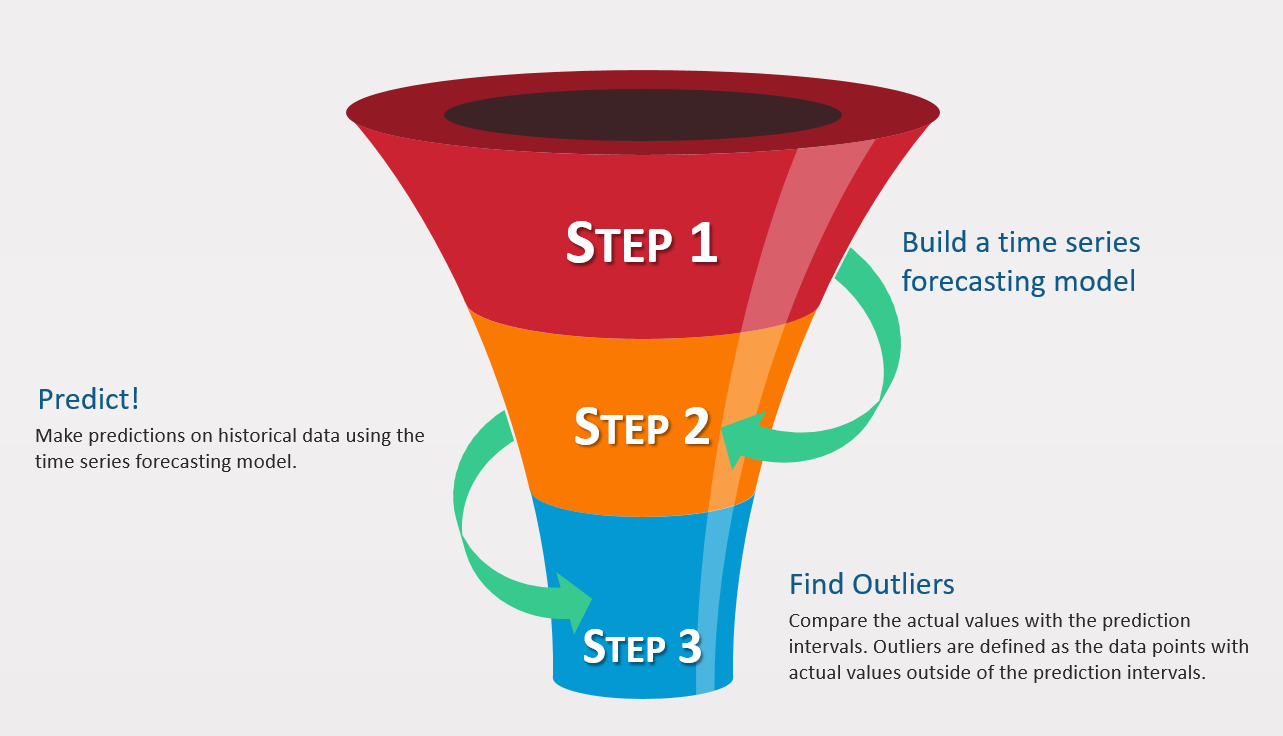

### Step 0.1
Install dependecies

In [ ]:
# Install libraries
!pip install yfinance prophet

# Get time series data from yahoo finance
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 9.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

## Step 0.2
####Pull the data <br>
The second step pulls stock data from Yahoo Finance API. Two years of daily data from the beginning of 2020 to the end of 2021 are pulled for this analysis.

In [ ]:
# Data start date
start_date = '2020-01-02'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01' 

The goal of the time series model is to predict the closing price of Google's stock, so Google's ticker `GOOG` is used for pulling the data.

Prophet requires at least two columns as inputs: a `ds` column and a `y` column.
* The `ds` column has the time information. Currently we have the date as the index, so we reset the index and rename `date` to `ds`.
* The y column has the time series values. In this example, because we are predicting Google's closing price, the column name for the price is changed to `y`.

In [ ]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

data.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-01-02 00:00:00-05:00,68.368500
2020-01-03 00:00:00-05:00,68.032997
2020-01-06 00:00:00-05:00,69.710503
2020-01-07 00:00:00-05:00,69.667000
2020-01-08 00:00:00-05:00,70.216003


In [ ]:
# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']

# Take a look at the data
data.head()

,ds,y
0,2020-01-02 00:00:00-05:00,68.368500
1,2020-01-03 00:00:00-05:00,68.032997
2,2020-01-06 00:00:00-05:00,69.710503
3,2020-01-07 00:00:00-05:00,69.667000
4,2020-01-08 00:00:00-05:00,70.216003


## STEP 0.3
Some quick EDA

lets check the data quickly using the `info` method

In [ ]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   ds      505 non-null    datetime64[ns, America/New_York]
 1   y       505 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(1)
memory usage: 8.0 KB


let’s visualize the closing prices of the two tickers

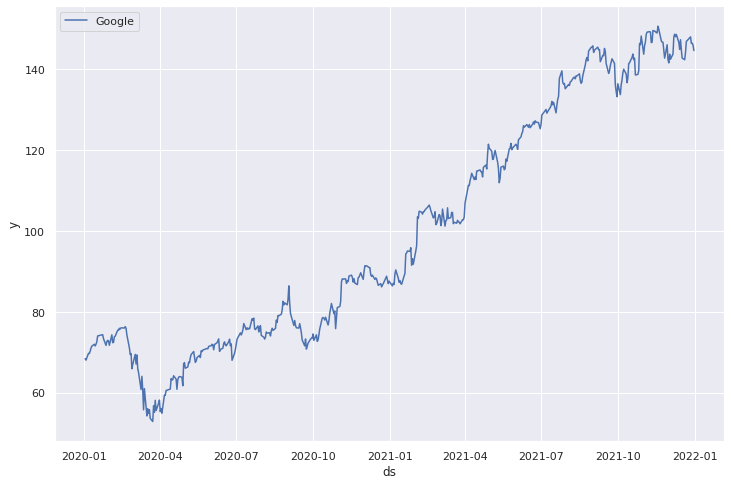

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

We can see that the price for Google increased a lot starting in late 2020, and almost doubled in late 2021.

## STEP 1
#### Build Time Series Model Using Prophet in Python

❗ NOTE:
we are not going to do train test split for the modeling dataset. This is because the goal of the model is not to predict future stock prices, instead, the goal is to fit a model that predicts well on the past prices. Therefore, we will use the whole dataset for both training and forecasting.

* When initiating the prophet model, the `yearly_seasonality` and `weekly_seasonality` are explicitly set to True, and then fit on the training data.
* The `interval_width` is set to 0.99, which means that the uncertainty interval is 99%.

### WAIT!!
what is that interval_width parameter exactly???

interval_width : Prophet predict returns uncertainty intervals for each component, like lower and upper thresholds for the forecasted y value.<br>
These are computed as quantiles of the predictive distribution, and interval_width specifies which quantiles to use. The default of 0.8 provides an 80% prediction interval.

In [ ]:
# Add seasonality
model = Prophet(interval_width=0.65, yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model.fit(data)

ValueError: ignored

#### We got an error because prophet doesn't care about my timezone. let's try again!

In [ ]:
# remove the timezone
data['ds'] = data['ds'].dt.tz_localize(None)

In [ ]:
# Fit the model on the training dataset
model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1nm2mq7/beyxcqs7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1nm2mq7/9p2t3x0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10392', 'data', 'file=/tmp/tmpb1nm2mq7/beyxcqs7.json', 'init=/tmp/tmpb1nm2mq7/9p2t3x0g.json', 'output', 'file=/tmp/tmpb1nm2mq7/prophet_modeldo4jpwn7/prophet_model-20230125213448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### STEP 2
#### Make Predictions!

After building the model, in step 1, we use the model to make predictions on the dataset and visualize!


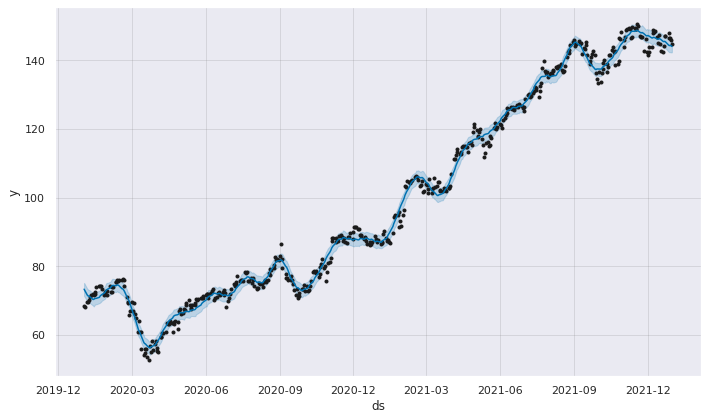

In [ ]:
# Make prediction
forecast = model.predict(data)
# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

Lets try now with differnt interval...

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1nm2mq7/_ca6hskp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1nm2mq7/3u517dw3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36186', 'data', 'file=/tmp/tmpb1nm2mq7/_ca6hskp.json', 'init=/tmp/tmpb1nm2mq7/3u517dw3.json', 'output', 'file=/tmp/tmpb1nm2mq7/prophet_modelb7zkigyi/prophet_model-20230125213450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


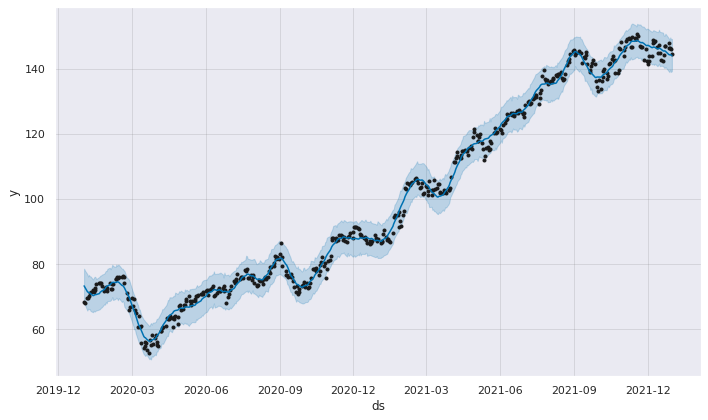

In [ ]:
# Add seasonality
model2 = Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model2.fit(data)

# Make prediction
forecast = model2.predict(data)

# Visualize the forecast
model2.plot(forecast); # Add semi-colon to remove the duplicated chart

The forecast plot shows that the predictions are in general aligned with the actual values.

We can also check the components plot for the trend, weekly seasonality, and yearly seasonality.

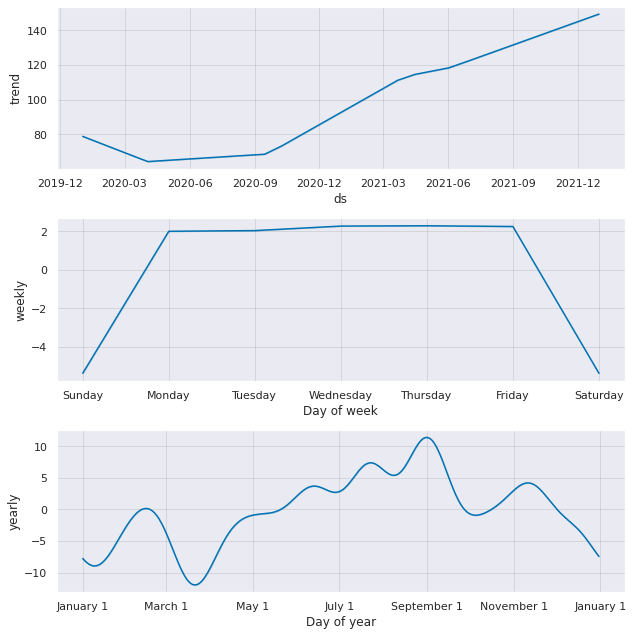

In [ ]:
# Visualize the forecast components
model2.plot_components(forecast);

#### Check Time Series Model Performance

The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the actual dataframe to compare the actual values with the predicted values.

In [ ]:
# Merge actual and predicted values
performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

Two performance metrics are included:

* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it’s undefined when the actual value is zero.


In [ ]:
# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')
# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 1.5738467261018003
The MAPE for the model is 0.016980422958756094


The mean absolute error (MAE) for the model is $1.57, meaning that on average, the forecast is off by $1.7. Given that price is in hundreds, the prediction is not bad.

The mean absolute percent error (MAPE) for the baseline model is 1.7%, meaning that on average, the forecast is off by 1.7% of the stock price.

## STEP 3:
#### Identify Anomalies

we will identify the time series anomalies by checking if the actual value is outside of the uncertainty interval. If the actual value is smaller than the lower bound or larger than the upper bound of the uncertainty interval, the anomaly indicator is set to 1, otherwise, it’s set to 0.

In [ ]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

Lets count the number of anomalies

In [ ]:
# Check the number of anomalies
performance['anomaly'].value_counts()

0    498
1      7
Name: anomaly, dtype: int64

We have 6 anomalies! lets check them...

In [ ]:
# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
208,2020-10-28,75.831001,82.250670,77.350702,86.951589,1
269,2021-01-27,91.539497,96.556595,91.811556,101.658067,1
271,2021-01-29,91.787003,97.760358,91.830587,102.396429,1
342,2021-05-12,111.954002,118.266206,113.411967,124.016934,1
343,2021-05-13,113.098503,118.393863,113.103898,123.401716,1
482,2021-11-30,142.451996,147.088253,142.544088,152.339756,1
483,2021-12-01,141.617996,147.213142,142.344694,152.308115,1


After printing out the anomalies, we can see that all the outliers are lower than the lower bound of the uncertainty interval.

Lets try to visualize them...

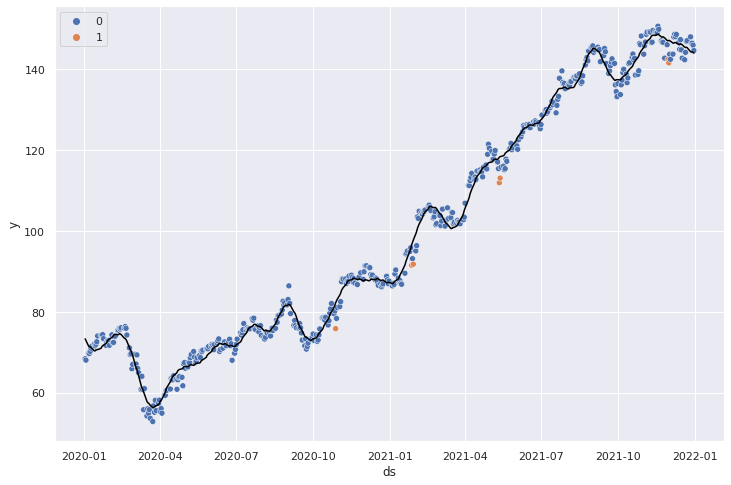

In [ ]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')

### Now, lets try something less stable... Bitcoin! 

try to change the ticker at the top to: `ticker_list = ['BTC-USD']`
and see the performance of that model